### library import

In [1]:
import numpy as np
import pandas as pd
import scipy.misc as scm
from scipy.stats import poisson
import scipy.integrate as integrate
import math
import random
from decimal import *

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### modelingクラス

In [30]:
 class modeling:
    # 1,準備
    # Poisson過程
    # 単位時間あたりの到着数 λ
    # 時刻tまでにn人が到着する確率
    def poisson_probability(self, n, t, lambda_poisson):
        return Decimal(math.e)**(Decimal(-1)*Decimal(lambda_poisson) * Decimal(t)) * (Decimal(lambda_poisson) * Decimal(t))**Decimal(n) / Decimal(math.factorial(Decimal(n)))

    # Poisson過程
    # 累積確率
    def cumulative_poisson_probability(self, n, t, lambda_poisson):
        return np.sum(Decimal(math.e)**(Decimal(-1) * Decimal(lambda_poisson) * Decimal(t)) * (Decimal(lambda_poisson) * Decimal(t))**Decimal(i) / Decimal(math.factorial(Decimal(i))) for i in range(0, n + 1))

    # Gamma分布
    # 時刻tにn人目が到着する確率
    def gamma_probability(self, n, t, lambda_poisson):
        return Decimal(lambda_poisson)**Decimal(n) * Decimal(t)**(Decimal(n) - Decimal(1)) * Decimal(math.e)**(Decimal(-1)*Decimal(lambda_poisson) * Decimal(t)) / Decimal(math.factorial(Decimal(n) - Decimal(1)))

    # Gamma分布
    # 累積確率
    def cumulative_gamma_probability(self, n, T, lambda_poisson):
        cumulative_probability, abserr = integrate.quad(lambda t: self.gamma_probability(n, t, lambda_poisson), 0, Decimal(T))
        return cumulative_probability

    # 時刻Tまでにn人現われるときに， 時刻t(=< T)にm(=< n)人目が到着する確率g(m,n,t,T)
    def g(self, m, n, t, T, lambda_poisson):
        return (Decimal(lambda_poisson)**Decimal(n) / (Decimal(math.factorial(Decimal(m) - Decimal(1))) * Decimal(math.factorial(Decimal(n) - Decimal(m))))) \
         * Decimal(t)**(Decimal(m) - Decimal(1)) * (Decimal(T) - Decimal(t))**(Decimal(n) - Decimal(m)) * Decimal(math.e)**(Decimal(-1) * Decimal(lambda_poisson) * Decimal(T))

    # 多数決による判定精度
    # n人で多数決を行う場合の判定精度をacc(n)で表す
    # 個人の判定精度をpとする
    def acc_odd(self, n, p): # nが奇数2i-1のとき
        i = int((n + 1) / 2)
        return Decimal(sum(scm.comb(2 * i - 1, j) * p**(2 * i - 1 - j) * (1 - p)**j for j in range(i)))

    def acc_even(self, n, p): # nが偶数2iのとき
        i = int(n / 2)
        return Decimal(sum(scm.comb(2 * i, j) * p**(2 * i - j) * (1 - p)**j for j in range(i)) + scm.comb(2 * i, i) * p**i * (1 - p)**i / 2)

    def acc(self, n, p):
        if n % 2 == 1:
            return self.acc_odd(n, p)
        else:
            return self.acc_even(n, p)

    # 2,単純な意見集約法

    # 2.1,時刻優先意見集約法
    # 時刻tまで待って多数決を行う
    # 効用を予測精度と所要時間の差で表す
    def time_priority_method(self, t, w, p, lambda_poisson):
        if t == 0: return 0
        return sum(self.poisson_probability(i, t, lambda_poisson) * self.acc(i, p) for i in range(1,200)) - (Decimal(w) * Decimal(t))

    # 増減を調べる
    def inc_and_dec_time_priority_method(self, w, p, lambda_poisson):
        for t in range(1, 1000):
            diff = self.time_priority_method(t + 1, w, p, lambda_poisson) - self.time_priority_method(t, w, p, lambda_poisson)
            if diff < 0: return t

    # 2.2, 投票数優先意見集約法
    # n人集まるまで待って多数決を行う
    # 効用を予測精度と所要時間の差で表す
    def poll_priority_method(self, n, w, p, lambda_poisson):
        if n == 0: return 0
        return self.acc(n, p) - Decimal(integrate.quad(lambda t: Decimal(w) * Decimal(t) * self.gamma_probability(n, t, lambda_poisson), Decimal(0), Decimal(1000))[0])

    # 増減を調べる
    def inc_and_dec_poll_priority_method(self, w, p, lambda_poisson):
        for n in range(1, 1000):
            diff = self.poll_priority_method(2 * n + 1, w, p, lambda_poisson) - self.poll_priority_method(2 * n - 1, w, p, lambda_poisson)
            if diff < 0: return 2 * n - 1
            
    # 2.3, 得票数優先意見集約法
    # 先にk票集まった案に決定する
    # 効用を予測精度と所要時間の差で表す
    def vote_priority_method(self, k, w, p, lambda_poisson):
        if k == 0: return 0
        return sum((scm.comb(j - 1, j - k) * p**(k - 1) * (1 - p)**(j - k) * p * integrate.quad(lambda t: (Decimal(1) - Decimal(w) * Decimal(t)) * self.gamma_probability(j, t, lambda_poisson), Decimal(0), Decimal(1000))[0]) \
         + (scm.comb(j - 1, j - k) * p**(j - k) * (1 - p)**(k - 1) * (1 - p) * integrate.quad(lambda t: (Decimal(0) - Decimal(w) * Decimal(t)) * self.gamma_probability(j, t, lambda_poisson), Decimal(0), Decimal(1000))[0]) for j in range(k, 2 * k))
    # 増減を調べる
    def inc_and_dec_vote_priority_method(self, w, p, lambda_poisson):
        for k in range(1, 1000):
            diff = self.vote_priority_method(k + 1, w, p, lambda_poisson) - self.vote_priority_method(k, w, p, lambda_poisson)
            if diff < 0: return k



### plotGraphクラス

In [31]:
class plotGraph:

    def __init__(self):
        sns.set_style("whitegrid")
        self.model = modeling()

    def plot_poisson(self, time, lambda_poisson):
        x_axis = np.linspace(0, 2 * time * lambda_poisson, 2 * time * lambda_poisson + 1)
        y_axis = []
        for x in x_axis:
            y_axis.append(self.model.poisson_probability(x, time, lambda_poisson))
        plt.title('poisson time: {0} lambda: {1}'.format(time, lambda_poisson))
        plt.xlabel('people')
        plt.ylabel('probability')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_cumulative_poisson(self, time, lambda_poisson):
        x_axis = np.linspace(0, 2 * time * lambda_poisson, 2 * time * lambda_poisson + 1)
        y_axis = []
        for x in x_axis:
            y_axis.append(self.model.cumulative_poisson_probability(int(x), time, lambda_poisson))
        plt.title('cumulative poisson time: {0} lambda: {1}'.format(time, lambda_poisson))
        plt.xlabel('people')
        plt.ylabel('probability')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_gamma(self, people, lambda_poisson):
        x_axis = np.linspace(0, 2 * people / lambda_poisson , 2 * people / lambda_poisson + 1)
        y_axis = []
        for x in x_axis:
            y_axis.append(self.model.gamma_probability(people, x, lambda_poisson))
        plt.title('gamma people: {0} lambda: {1}'.format(people, lambda_poisson))
        plt.xlabel('time')
        plt.ylabel('probability')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_cumulative_gamma(self, people, lambda_poisson):
        x_axis = np.linspace(0, 2 * people / lambda_poisson , 2 * people / lambda_poisson + 1)
        y_axis = []
        for x in x_axis:
            y_axis.append(self.model.cumulative_gamma_probability(people, x, lambda_poisson))
        plt.title('cumulative gamma people: {0} lambda: {1}'.format(people, lambda_poisson))
        plt.xlabel('time')
        plt.ylabel('probability')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_g(self, m, n, T, lambda_poisson):
        x_axis = np.linspace(0, T, T + 1)
        y_axis = []
        for x in x_axis:
            y_axis.append(self.model.g(m, n, x, T, lambda_poisson))
        plt.title("g m: {0} n: {1} T:{2} lambda: {3}".format(m, n, T, lambda_poisson))
        plt.xlabel('time')
        plt.ylabel('probability')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_time_priority(self, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [self.model.time_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('time priority method weight: {0} person_probability: {1}'.format(w, p))
        plt.xlabel('time')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_poll_priority(self, w, p, lambda_poisson):
        x_axis = np.linspace(50, 130, 81)
        y_axis = [self.model.poll_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('poll priority method weight: {0} person_probability: {1}'.format(w, p))
        plt.xlabel('poll people')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_vote_priority(self, w, p, lambda_poisson):
        x_axis = np.linspace(30, 50, 21)
        y_axis = [self.model.vote_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('vote priority method weight: {0} person_probability: {1}'.format(w, p))
        plt.xlabel('require vote people')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_method1(self, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [self.model.time_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('method1 weight: {0} person_probability: {1}'.format(w, p))
        plt.xlabel('time')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_method2(self, T1, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [self.model.method2(T1,int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('method2 T1: {0} weight: {1} person_probability: {2}'.format(T1, w, p))
        plt.xlabel('poll people')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_method3(self, T1, T2, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [self.model.method3(T1, T2, int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('method3 T1: {0} T2: {1} weight: {2} person_probability: {3}'.format(T1, T2, w, p))
        plt.xlabel('poll people')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_method4(self, T1, w, p, lambda_poisson):
        x_axis = np.linspace(0, 14, 15)
        y_axis = [self.model.method4(T1,int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('method4 T1: {0} weight: {1} person_probability: {2}'.format(T1, w, p))
        plt.xlabel('require vote people')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_method5(self, T1, T2, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [self.model.method5(T1, T2, int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('method5 T1: {0} T2: {1} weight: {2} person_probability: {3}'.format(T1, T2, w, p))
        plt.xlabel('poll people')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()

### main

In [32]:
sns.set_style("whitegrid")
m = modeling()
pg = plotGraph()

w = 0.003
p = 0.6
lambda_poisson = 3

# print "------------時間優先------------"
# print m.inc_and_dec_time_priority_method(w, p, lambda_poisson)
# print m.time_priority_method(m.inc_and_dec_time_priority_method(w, p, lambda_poisson), w, p, lambda_poisson)
# print "------------------------------------"
# print "------------投票数優先------------"
# print m.inc_and_dec_poll_priority_method(w, p, lambda_poisson)
# print m.poll_priority_method(m.inc_and_dec_poll_priority_method(w, p, lambda_poisson), w, p, lambda_poisson)
# print "------------------------------------"
# print "------------得票数優先------------"
# print m.inc_and_dec_vote_priority_method(w, p, lambda_poisson)
# print m.vote_priority_method(m.inc_and_dec_vote_priority_method(w, p, lambda_poisson), w, p, lambda_poisson)
# print "------------------------------------"
# print "------------方法1------------"
# print m.inc_and_dec_method1(w, p, lambda_poisson)
# print m.method1(m.inc_and_dec_method1(w, p, lambda_poisson), w, p, lambda_poisson)
# print "------------------------------------"
# print "------------方法2------------"
# print m.inc_and_dec_method2(50, w, p, lambda_poisson)
# print m.method2(50, m.inc_and_dec_method2(50, w, p, lambda_poisson), w, p, lambda_poisson)
# print "------------------------------------"
# print "------------方法3------------"
# print m.inc_and_dec_method3(40, 20, w, p, lambda_poisson)
# print m.method3(40, 20, m.inc_and_dec_method3(40, 20, w, p, lambda_poisson), w, p, lambda_poisson)
# print "------------------------------------"
# print "------------方法4------------"
# print m.inc_and_dec_method4(3, w, p, lambda_poisson)
# print m.method4(3, m.inc_and_dec_method4(3, w, p, lambda_poisson), w, p, lambda_poisson)
# print "------------------------------------"


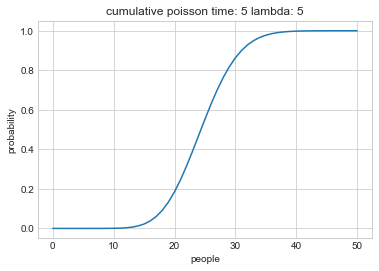

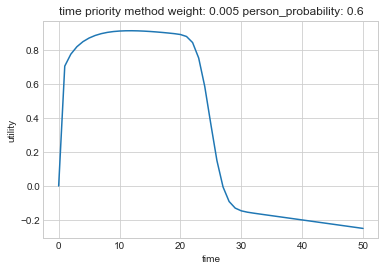

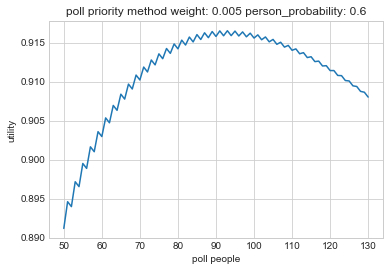

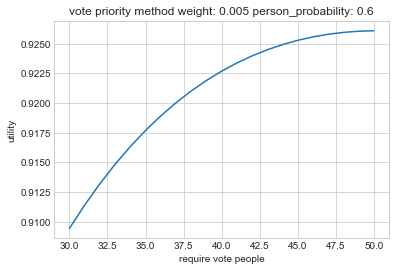

In [33]:
w = 0.005
p = 0.6
lambda_poisson = 8

# pg.plot_poisson(30,1)
pg.plot_cumulative_poisson(5,5)
# pg.plot_gamma(100,5)
# pg.plot_cumulative_gamma(100, 1)
# pg.plot_g(10, 20, 10, 2)

pg.plot_time_priority(w, p, lambda_poisson)
pg.plot_poll_priority(w, p, lambda_poisson)
pg.plot_vote_priority(w, p, lambda_poisson)
# pg.plot_method1(w, p, lambda_poisson)
# pg.plot_method2(30, w, p, lambda_poisson)
# pg.plot_method3(30, 20, w, p, lambda_poisson)
# pg.plot_method4(15, 0.02, 0.6, 1)
# pg.plot_method5(40, 40, 0.02, 0.6, 1)

### 表を描画

In [ ]:
arr_2 = range(0, 10)
m = modeling()

w = 0.001
p = 0.7
lambda_poisson = 1

fundamental_df = pd.DataFrame({
    'A: time_priority': [m.time_priority_method(t, w, p, lambda_poisson) for t in arr_2],
#     'B: poll_priority': [m.poll_priority_method(n, w, p, lambda_poisson) for n in arr_2],
#     'C: vote_priority': [m.vote_priority_method(k, w, p, lambda_poisson) for k in arr_2],
})

# print m.time_priority_method(60, w, p, lambda_poisson)
# print m.poll_priority_method(90, w, p, lambda_poisson)
# print m.vote_priority_method(80, w, p, lambda_poisson)

In [ ]:
fundamental_df.style.highlight_max()

In [ ]:
arr = range(0, 15)
m = modeling()

w = 0.01
p = 0.6
lambda_poisson = 1


m2_df = pd.DataFrame({
    'a1': [m.method2(1, n, w, p, lambda_poisson) for n in arr],
    'b2': [m.method2(2, n, w, p, lambda_poisson) for n in arr],
    'c3': [m.method2(3, n, w, p, lambda_poisson) for n in arr],
    'd4': [m.method2(4, n, w, p, lambda_poisson) for n in arr],
    'e5': [m.method2(5, n, w, p, lambda_poisson) for n in arr],
    'f6': [m.method2(6, n, w, p, lambda_poisson) for n in arr],
    'g7': [m.method2(7, n, w, p, lambda_poisson) for n in arr],
    'h8': [m.method2(8, n, w, p, lambda_poisson) for n in arr],
    'i9': [m.method2(9, n, w, p, lambda_poisson) for n in arr],
    'j10': [m.method2(10, n, w, p, lambda_poisson) for n in arr],
    'k11': [m.method2(11, n, w, p, lambda_poisson) for n in arr],
    'l12': [m.method2(12, n, w, p, lambda_poisson) for n in arr],
    'm13': [m.method2(13, n, w, p, lambda_poisson) for n in arr],
    'n14': [m.method2(14, n, w, p, lambda_poisson) for n in arr],
    'o15': [m.method2(15, n, w, p, lambda_poisson) for n in arr],
    'p18': [m.method2(18, n, w, p, lambda_poisson) for n in arr],
    'q21': [m.method2(21, n, w, p, lambda_poisson) for n in arr],
    'r24': [m.method2(24, n, w, p, lambda_poisson) for n in arr],
    's27': [m.method2(27, n, w, p, lambda_poisson) for n in arr],
    't30': [m.method2(30, n, w, p, lambda_poisson) for n in arr],
})

In [ ]:
m2_df.style.highlight_max()

In [ ]:
arr = range(0, 15)
m = modeling()

w = 0.01
p = 0.6
lambda_poisson = 1

m3_df = pd.DataFrame({
    'a1': [m.method3(30,1, n, w, p, lambda_poisson) for n in arr],
    'b2': [m.method3(30,2, n, w, p, lambda_poisson) for n in arr],
    'c3': [m.method3(30,3, n, w, p, lambda_poisson) for n in arr],
    'd4': [m.method3(30,4, n, w, p, lambda_poisson) for n in arr],
    'e5': [m.method3(30,5, n, w, p, lambda_poisson) for n in arr],
    'f6': [m.method3(30,6, n, w, p, lambda_poisson) for n in arr],
    'g7': [m.method3(30,7, n, w, p, lambda_poisson) for n in arr],
    'h8': [m.method3(30,8, n, w, p, lambda_poisson) for n in arr],
    'i9': [m.method3(30,9, n, w, p, lambda_poisson) for n in arr],
    'j10': [m.method3(30,10, n, w, p, lambda_poisson) for n in arr],
    'k11': [m.method3(30,11, n, w, p, lambda_poisson) for n in arr],
    'l12': [m.method3(30,12, n, w, p, lambda_poisson) for n in arr],
    'm13': [m.method3(30,13, n, w, p, lambda_poisson) for n in arr],
    'n14': [m.method3(30,14, n, w, p, lambda_poisson) for n in arr],
    'o15': [m.method3(30,15, n, w, p, lambda_poisson) for n in arr],
    'p16': [m.method3(30,16, n, w, p, lambda_poisson) for n in arr],
    'q24': [m.method3(30,24, n, w, p, lambda_poisson) for n in arr],
    'r26': [m.method3(30,26, n, w, p, lambda_poisson) for n in arr],
    's28': [m.method3(30,28, n, w, p, lambda_poisson) for n in arr],
    't30': [m.method3(30,30, n, w, p, lambda_poisson) for n in arr],
})

In [ ]:
m3_df.style.highlight_max()

In [ ]:
# sns.set_style("whitegrid")
# pg = PlotGraph(50, 2)
# pg.plot_error_possibility_graph(5)
# pg.plot_error_possibility_graph_by_people_num()
# pg.plot_utility_possibility_average_graph(11, 13, 17, 0.5)
# pg.plot_utility_possibility_variance_graph(11, 13, 17, 0.5)
# pg.plot_utility_weight_average_graph(0.7, 11, 13, 17)
# pg.plot_utility_weight_variance_graph(0.7, 11, 13, 17)
# pg.plot_utility_possibility_average_graph_for_single_method(0.5)
# pg.plot_utility_possibility_variance_graph_for_single_method(0.5)
# pg.plot_utility_weight_average_graph_with_uniform_distribution(50, 50, 11, 13, 17)
# pg.plot_utility_weight_variance_graph_with_uniform_distribution(50, 50, 11, 13, 17)
# pg.plot_utility_weight_average_graph_with_uniform_distribution_for_single_method(50, 50)
# pg.plot_utility_weight_variance_graph_with_uniform_distribution_for_single_method(50, 50)

### テスト

In [ ]:
m = modeling()

# integrate g and poisson should be same
# def temp_f(t):
#     return m.g(4,10,t,5,2)
# value, abserr = integrate.quad(temp_f, 0, 5)
# print value
# print m.poisson_probability(10,5,2)
# print "--------------------------------------------------"

# # p_sum plus g_value should be 1.0
# p_sum = 0
# for i in range(0, 50):
#     p_sum += m.poisson_probability(i, 20, 3)
# print p_sum
# def test_g(t):
#     return m.trial_g(50, t, 20, 3)
# g_value, abserr = integrate.quad(test_g, 0, 20)
# print g_value
# print "--------------------------------------------------"

# # method2 p_sum should be 1.0
# def method2_p_sum(T1, n, w, lambda_poisson):
#     p_sum = 0
#     for i in range(0, n):
#         p_sum += m.poisson_probability(i, T1, lambda_poisson)
#     # 積分を行う
#     value, abserr = integrate.quad(lambda t: m.gamma_probability(n, t, lambda_poisson), 0, T1)
#     p_sum += value
#     return p_sum
# print method2_p_sum(20, 10, 0.02, 1)
# print "--------------------------------------------------"

# method3 p_sum should be 1.0
# def method3_p_sum(T1, T2, n, w, lambda_poisson):
#     p_sum = 0
#     for i in range(0, n):
#         p_sum += m.poisson_probability(i, T1, lambda_poisson)
#     for i in range(n, 100):
#         value_1, abserr = integrate.quad(lambda t: m.g(n, i, t, T1, lambda_poisson), 0, T2)
#         value_2, abserr = integrate.quad(lambda t: m.g(n, i, t, T1, lambda_poisson), T2, T1)
#         p_sum += value_1
#         p_sum += value_2
#     return p_sum
# print method3_p_sum(30, 14, 10, 0.02, 1)
# print "--------------------------------------------------"

# vote priority method acc (頭がこんがらがったので確かめ)
# def vote_priority_method(k, p):
#     if k == 0: return 0
#     acc = 0
#     for j in range(k, 2 * k):
#         acc += scm.comb(j - 1, j - k) * p**(k - 1) * (1 - p)**(j - k) * p
#     return acc
# print vote_priority_method(1, 0.9)
# print "--------------------------------------------------"

# method4 p_sum should be 1.
# def method4_p_sum(T1, k, p, lambda_poisson):
#     if k == 0: return 0
#     p_sum = 0
#     for i in range(0, k):
#         for j in range(i, 2 * i):
#             p_sum += m.poisson_probability(j, T1, lambda_poisson) * (scm.comb(j - 1, j - i) * p**(i - 1) * (1 - p)**(j - i) * p)
#     # ----被積分関数を定義----
#     def integrand_for_method4(t):
#         integrand = 0
#         for j in range(k, 2 * k):
#             integrand += m.gamma_probability(j, t, lambda_poisson) * (scm.comb(j - 1, j - k) * p**(k - 1) * (1 - p)**(j - k) * p)
#         return integrand
#     # --------終わり--------
#     #積分を行う
#     value, abserr = integrate.quad(integrand_for_method4, 0, T1)
#     p_sum += value
#     return p_sum
# print method4_p_sum(20, 30, 0.9, 1)

In [ ]:
# from decimal import *

getcontext()
getcontext().prec = 28

print Decimal(2.0 ** 0.5)
print 2.0 ** 0.5

In [ ]:
%time
test_sum = 0
for i in range(10000000):
    test_sum += i*i
print test_sum


In [ ]:
%time
print sum(i*i for i in range(10000000))

In [15]:
integrate.quad(lambda t: 2 * t, 0, 10)[0]

100.0